In [2]:
import re
import random
import pandas as pd
import hashlib

In [3]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [4]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Files Documentation,69.380872,2.168152,12.543897,32
Python + Oauth2.0,86.146366,3.745494,14.697619,23
DAX,108.023222,36.007741,44.201355,3
PowerShell Modules,165.414299,41.353575,68.645540,4
Pandas,261.207381,43.534563,53.378387,6
Terraform,843.090450,84.309045,210.027683,10
Azure DevOps Pipelines,966.167380,96.616738,193.485862,10
Power BI,974.941099,29.543670,48.822401,33
Terraform Codebox,1105.329356,22.557742,52.933269,49
Azure Functions + PP365,1247.540699,89.110050,145.220246,14


# Histogram

sum of ages: ~47129.43


<Axes: >

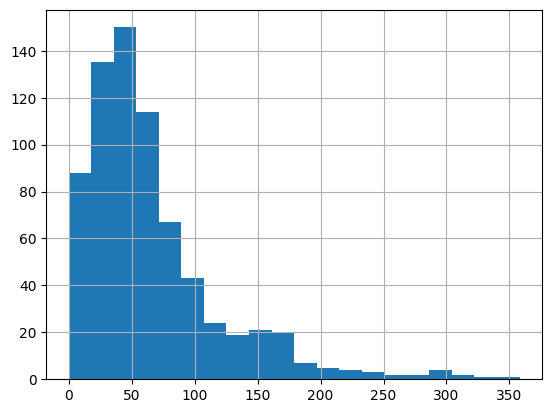

In [6]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~-47129.43


<Axes: >

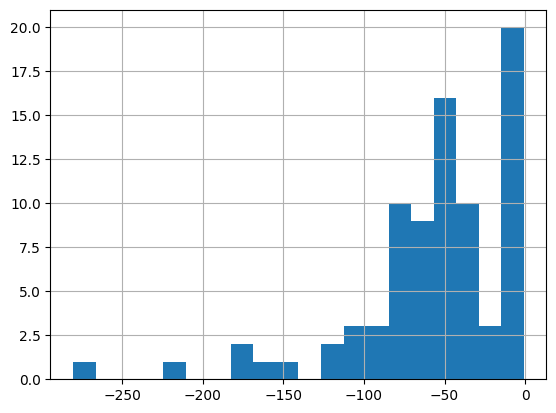

: 

In [ ]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='JavaScript Concepts']['age'].hist(bins=20)

# Completely Random Shuffle

In [8]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [9]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [10]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [12]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [13]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [14]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [ ]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


Cards found: 712
Total card age: 47129.43


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
77,JavaScript Concepts,Array Length Property: Remember to use array.l...,c02c010bacfe4a921dae3865e144c2bb,-280.680057,56.576428,280.680057,-4639.26708,0.370896,82,0,0
80,JavaScript Concepts,RESTful APIs: Architectural style for designin...,715b060fac6fe370580aac7dda729275,-176.104227,56.576428,280.680057,-4639.26708,0.370896,82,3,0
170,JavaScript Concepts,Chai: An assertion library that pairs with tes...,5ac89f673c3d8903f53058993c7f5d9b,-119.330289,56.576428,280.680057,-4639.26708,0.370896,82,6,0
245,JavaScript Concepts,"NaN is not equal to itself (NaN !== NaN), so u...",13b4fa482b9e8f54f169b5fe483f69ec,-106.184636,56.576428,280.680057,-4639.26708,0.370896,82,9,0
312,JavaScript Concepts,Testing Library: A family of libraries that en...,5d5076c5b421e0c332ab527a1dea9dff,-91.914753,56.576428,280.680057,-4639.26708,0.370896,82,12,0
315,JavaScript Concepts,"In JavaScript, you can only return exactly one...",ff371a8725914a03ceed40564889f505,-81.985141,56.576428,280.680057,-4639.26708,0.370896,82,15,0
377,JavaScript Concepts,Array slice Function: The slice method returns...,c46c6b6e8ee659e701bafd69ca2c9c31,-77.031300,56.576428,280.680057,-4639.26708,0.370896,82,18,0
439,JavaScript Concepts,JavaScript's array destructuring syntax is a c...,d1873d9f239196132e5ff5341adb3922,-75.774838,56.576428,280.680057,-4639.26708,0.370896,82,21,0
490,JavaScript Concepts,Array slice Function: The slice method returns...,778fbf79a240ab27c85f2d9f873b2391,-70.240370,56.576428,280.680057,-4639.26708,0.370896,82,24,0
493,JavaScript Concepts,Using Object.entries(): The Object.entries() m...,e5db3c2db787ca033cb30767e93f5386,-61.649809,56.576428,280.680057,-4639.26708,0.370896,82,27,0


## Age Mean

In [ ]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

## Age Max

In [17]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [18]:
# n=4
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [19]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [20]:
existing_cards.head(10)['age'].sum()

np.float64(-1140.895420280859)

In [21]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
45,Asynchronous Python,Coroutine Object\nThe result of calling an asy...,877cc6e7d0264598007bf336b88f4c3e,-357.997261,99.109145,357.997261,-3270.601782,0.645371,33,0,0
29,FSLogix,Redirector Driver:\nA mechanism within FSLogix...,f51a72bfb75cf817d822f0fb50b94a12,-334.217359,89.585500,334.217359,-2418.808491,0.560012,27,0,0
9,Azure Developer Associate,What's the recommended authentication method f...,92c7baf1544a3d6d4ced3a3057810fec,-318.993148,133.311547,318.993148,-1733.050113,0.068614,13,0,0
21,C# Basics,What are common libraries and frameworks in C#...,d714cbc1740b344f84ed84278b332f36,-304.319711,92.040105,304.319711,-2208.962514,0.725973,24,0,0
30,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,-304.150727,89.585500,334.217359,-2418.808491,0.560012,27,1,1
73,Python,Q:\nWhat is the primary purpose of exit codes ...,d5ae26a1eb6bf1e733080a8396f21e2d,-303.552877,81.059253,303.552877,-4296.140434,0.464783,53,0,0
69,Vocab,Palimpsest\nnoun\nSPA: PAL-imps-est\nIPA: /ˈpæ...,83dd5618c76e96fde6405f55d07dbe7d,-301.962313,81.267430,301.962313,-4063.371484,0.541044,50,0,0
61,PnP PowerShell,Export-PnPProvisioningTemplate (PnP.PowerShell...,fa28f8230bbc691d7374863ca568f6cc,-286.513047,89.822358,286.513047,-4401.295560,0.416926,49,0,0
77,JavaScript Concepts,Array Length Property: Remember to use array.l...,c02c010bacfe4a921dae3865e144c2bb,-280.680057,56.576428,280.680057,-4639.267080,0.370896,82,0,0
74,Python,Q:\nHow can you define a custom exception in P...,42a1f83efefd4b56173827e48cae56f3,-278.118290,81.059253,303.552877,-4296.140434,0.464783,53,1,1


In [22]:
existing_cards['age'].mean()

np.float64(-66.19302097559482)